In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
import torch
from collections import defaultdict
import re
from scipy.spatial import distance
import scipy
import warnings
import plotly.express as px
import pandas as pd
import glob
from multiprocessing import Pool
from scipy.spatial import distance
import xml.etree.ElementTree as ET




/data/siyer/SSIE-519-Soft-Computing-Final-project--Srikanth--Annajirao/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Definitions

## Corpus

## loading corpus

In [2]:

corpus = []

def load_corpus(directory):
    """
    Load the corpus from the directory and return a list of all lemma words

    Parameters:
    - directory (str): The directory path where the XML files are located.

    Returns:
    - corpus (list): A list of lemma words based on the input after hw=.

    Example:
    >>> directory = '../Other_text_data/bnc/2553/Texts/fic'
    >>> corpus = load_corpus(directory)
    """

    corpus = []
    file_paths = glob.glob(os.path.join(directory, '**/*.xml'), recursive=True)

    for file_path in file_paths:
        tree = ET.parse(file_path)
        root = tree.getroot()

        for word in root.iter('w'):
            lemma = word.get('hw')
            corpus.append(lemma)

    print(f'Length of Corpus: {len(corpus)}')
    print(f'First 20 words in the corpus: {corpus[:20]}')
    return corpus



## context splitting

In [3]:
def context_splitting(corpus, context_length=1000):
    """
    Split the corpus into contexts of length context_length

    Parameters:
    - corpus (list): A list of words
    - context_length (int): The length of each context

    Returns:
    - contexts (list): A list of contexts, where each context is a list of words

    Example:
    >>> corpus = ['a', 'b', 'c', 'd', 'e', 'f']
    >>> context_length = 2
    >>> context_splitting(corpus, context_length)
    [['a', 'b'], ['c', 'd'], ['e', 'f']]
    
    """
    
    current_context = []
    contexts = []

    for word in corpus:
        current_context.append(word)
        if len(current_context) == context_length:
            contexts.append(current_context)
            current_context = []

    if current_context:
        contexts.append(current_context)
    
    return contexts



## Co-occurence matrix def: create_co_occurrence_matrix(corpus)

In [4]:
def create_co_occurrence_matrix(corpus, contexts, min_frequency = 5):
    '''
    Create a co-occurrence matrix based on the given corpus and contexts.

    Parameters:
    - corpus (list): A list of words representing the corpus.
    - contexts (list): A list of lists, where each inner list represents a context of default length 1000 words unless specified otherwise.
    - min_frequency (int): The minimum number of times a word must appear in the corpus to be included in the co-occurrence matrix.

    Returns:
    - co_occurrence_matrix (numpy.ndarray): The rows represent words and the columns represent contexts. The value at (i, j) represents the number of times word i appears in context j.

    - word_to_index (dict): A dictionary mapping words to their corresponding indices in the matrix.
    
    - index_to_word (dict): A dictionary mapping indices to their corresponding words in the matrix.

    Example usage:
    corpus = ["the", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]
    contexts = [["the", "quick", "brown"], ["fox", "jumps", "over"], ["the", "lazy", "dog"]]
    co_occurrence_matrix, word_to_index, index_to_word = create_co_occurrence_matrix(corpus, contexts)
    print(co_occurrence_matrix)
    print(word_to_index)
    print(index_to_word)
    
    '''

    distinct_words = sorted(list(set(corpus)))
    num_words = len(distinct_words)
    num_contexts = len(contexts)
   
    print(f"Number of distinct words: {num_words}")
    print(f"Number of words in corpus: {len(corpus)}")

    # Create word to index and index to word mappings
    word_to_index = {word: index for index, word in enumerate(distinct_words)}
    index_to_word = {index: word for index, word in enumerate(distinct_words)}
    

    # only words with minimum 10 appearances in corpus are inculeded in the co-occurrence matrix
    word_counts = defaultdict(int)
    for word in corpus:
        word_counts[word] += 1

    for i, word in enumerate(distinct_words):
        if word_counts[word] >= min_frequency:
            word_to_index[word] = i 
            index_to_word[i] = word
        else:
            del word_to_index[word]
            del index_to_word[i]
    # Rearrange the word to index and index to word mappings
    word_to_index = {word: index for index, word in enumerate(word_to_index.keys())}
    index_to_word = {index: word for word, index in word_to_index.items()}

    num_words = len(word_to_index)
    print(f"Number of distinct words with at least {min_frequency} appearances: {num_words}")

    # Initialize co-occurrence matrix
    co_occurrence_matrix = np.zeros((num_words, num_contexts))

    # Iterate over each context
    for context_index, context in enumerate(contexts):
        # Iterate over each word in the index that is in the context

        for word in context:
            if word not in word_to_index:
                continue
            word_index = word_to_index[word]
            co_occurrence_matrix[word_index, context_index] += 1
    
    return co_occurrence_matrix, word_to_index, index_to_word

# Example usage:
# corpus = ["the", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]
# contexts = [["the", "quick", "brown"], ["fox", "jumps", "over"], ["the", "lazy", "dog"]]

# co_occurrence_matrix, word_to_index, index_to_word = create_co_occurrence_matrix(corpus[:10000], contexts)
# print(co_occurrence_matrix)
# # print(word_to_index)


## Prep co-occurence matrix for svd 

Based on the paper:
Prior to SVD, values in the matrix were log-transformed. The logs associated with each word were then divided by that word’s entropy (H) in the corpus: $$H  = \sum_{c} p_c \log{(p_c)}$$  where $c$ indexes the different contexts in which the word appears and $p_c$ denotes the word’s frequency in the context divided by its total frequency in the corpus. 
These standard transformations were performed to reduce the influence of very high-frequency function words whose patterns of occurrence were not relevant in generating the semantic space (Landauer & Dumais, 1997).

In [5]:
def prepare_co_occurrence(co_occurrence_matrix, word_to_index):
    # Suppress warnings for dividing by zero
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # print(f'Co-occurrence matrix: {co_occurrence_matrix}')
    # print(f'Co-occurrence matrix shape: {co_occurrence_matrix.shape}')
    # print(f'Word to index mapping length: {len(word_to_index)}')
    # print(f'Index to word mapping length: {len(index_to_word)}')

    # print(f'total word in first context: {len(contexts[0])} and total via matrix: {np.sum(co_occurrence_matrix[:,0])}')

    # dividing frequency of occurrence of each word in each context by the total frequency of occurrence of the word in all contexts
    prob = np.divide(co_occurrence_matrix, np.sum(co_occurrence_matrix, axis=1).reshape(-1, 1))
    # print(f'Probability of each word in all contexts: {prob}')
    # print(f'Probability of each word in all contexts shape: {prob.shape}')

    # log transformation of the prob variable, if the each entry is not 0, else replace with 0
    log_prob = np.where(prob > 0, np.log(prob), prob)
    # log_prob = np.nan_to_num(log_prob)
    # print(f'Log transformation of the probability matrix: {log_prob}')
    # print(f'Log transformation of the probability matrix shape: {log_prob.shape}')

    # applying pointwise multiplication of the log transformed matrix and the prob matrix
    per_context_entropy_matrix = np.multiply(log_prob, prob)
    # print(f'Pointwise multiplication of the log transformed matrix and the prob matrix: {per_context_entropy_matrix}')
    # print(f'Pointwise multiplication of the log transformed matrix and the prob matrix shape: {per_context_entropy_matrix.shape}')

    # adding all pointwise multiplication values for each word
    word_entropies = np.sum(per_context_entropy_matrix, axis=1)
    # print(f'Entropy of each word in within the whole corpus: {word_entropies}')
    # print(f'Entropy of each word in within the whole corpus shape: {word_entropies.shape}')

    #reshaping word entropies to match the shape of the co-occurrence matrix
    word_entropies = np.reshape(word_entropies, (len(word_entropies), 1))
    # print(f'Entropy of each word in within the whole corpus reshaped: {word_entropies}')
    # print(f'Entropy of each word in within the whole corpus reshaped shape: {word_entropies.shape}')

    # log transform the co-occurrence matrix but if the value is 0, replace with 0
    co_occurrence_matrix = -np.where(co_occurrence_matrix > 0, np.log(co_occurrence_matrix), co_occurrence_matrix)
    co_occurrence_matrix = np.nan_to_num(co_occurrence_matrix)
    # print(f'Log transformation of the co-occurrence matrix: {co_occurrence_matrix}')

    # dividing the occurrence of each word in each context by the entropy of the word i.e. divide each number in each row by the number in word_entropy[row]
    co_occurrence_matrix = np.divide(co_occurrence_matrix, word_entropies)
    
    # print(f'Co-occurrence matrix(first two entries) : {co_occurrence_matrix[:2]}')  
    # print(f'Co-occurrence matrix shape: {co_occurrence_matrix.shape}') # (number of words, number of contexts)

    # Remove infinities and NaNs
    co_occurrence_matrix = np.nan_to_num(co_occurrence_matrix)
    
    # Reset warnings filter to default
    warnings.filterwarnings("default", category=RuntimeWarning)

    return co_occurrence_matrix




## SVD def: svd(co-occurrence_matrix)

In [6]:
def svd(co_occurrence_matrix):
    '''
    Singular Value Decomposition
    - `u` represents the left singular vectors and contains information about the relationships between the rows of the original matrix. 
    The rows of the co-occurrence matrix represent the words in the corpus, so the left singular vectors contain information about the relationships between the words.

    - `s` represents the singular values and contains information about the importance of each singular vector.

    - `v` represents the right singular vectors and contains information about the relationships between the columns of the original matrix.
    The columns of the co-occurrence matrix represent the contexts in which the words appear, so the right singular vectors contain information about the relationships between the contexts.
    '''
    # Singular Value Decomposition 
    u, s, v = np.linalg.svd(co_occurrence_matrix, full_matrices=False)
    v = np.transpose(v)
    print(f'U shape: {u.shape}')
    print(f'S shape: {s.shape}')
    print(f'V shape: {v.shape}')
    return u, s, v

## LSA def:  perform_lsa(corpus)

In [7]:
def perform_lsa(corpus, context_length=1000, min_frequency = 5):
    """
    Perform Latent Semantic Analysis on the given corpus.

    Parameters:
    - corpus (list): A list of words representing the corpus.
    - context_length (int): The length of each context.
    - min_frequency (int): The minimum number of times a word must appear in the corpus to be included in the co-occurrence matrix.

    Returns:
    - word_vectors (dict): A dictionary mapping words to their corresponding vectors.
    - context_vectors (numpy.ndarray): A matrix where the rows represent contexts and the columns represent the latent dimensions.
    - word_to_index (dict): A dictionary mapping words to their corresponding indices in the matrix.
    - contexts (list): A list of lists, where each inner list represents a context of length context_length.

    """
    contexts = context_splitting(corpus, context_length)
    co_occurrence_matrix, word_to_index, index_to_word = create_co_occurrence_matrix(corpus,contexts, min_frequency = min_frequency)


    # print(f'Co occurance matrix shape: {co_occurrence_matrix.shape}')
    # print(f'Word to index mapping length: {len(word_to_index)}')
    # print(f'Index to word mapping length: {len(index_to_word)}')

    co_occurrence_matrix = prepare_co_occurrence(co_occurrence_matrix, word_to_index)

    # Perform singular value decomposition
    u, s, v = svd(co_occurrence_matrix)

    # word_vectors = {word: u[i, :300] for i, word in enumerate(index_to_word)} # 300 dimensions is supposedly optimal according to the article.
    word_vectors = {word: u[i, :] for i, word in enumerate(index_to_word)} # I'm doing all values unlike the article, because I'm not sure if the 300 dimensions are optimal.
    # context_vectors = vt[:300, :]
    context_vectors = v[:, :]

    print(f'Word vectors length: {len(word_vectors)}')
    print(f'Context vectors length: {len(context_vectors)}')
    
    return word_vectors, context_vectors, word_to_index, contexts


In [8]:
def get_cosine_similarity(word1, word2, word_vectors, word_to_index):
    """
    Calculate the cosine similarity between two words.
    
    Args:
        word1 (str): The first word.
        word2 (str): The second word.
        word_vectors (dict): A dictionary mapping words to LSA vectors.
    
    Returns:
        cosine_similarity (float): The cosine similarity between the two words.
    """
    if word1 not in word_to_index or word2 not in word_to_index:
        return print("One or both of the words are not in the index")
    
    vector1 = word_vectors[word_to_index[word1]]
    vector2 = word_vectors[word_to_index[word2]]
    
    # Calculate dot product
    dot_product = np.dot(vector1, vector2)    

    # Calculate magnitudes
    magnitude1 = np.sqrt(np.sum(vector1**2))
    magnitude2 = np.sqrt(np.sum(vector2**2))

    # Prevent division by zero
    if magnitude1 == 0 or magnitude2 == 0:
        return 

    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    
    return cosine_similarity

# word1= "man"
# word2= "woman"
# print(f'Cosine similarity between {word1} and {word2}: {get_cosine_similarity(word1, word2, word_vectors, word_to_index)}')

# word1= "boy"
# word2= "girl"
# print(f'Cosine similarity between {word1} and {word2}: {get_cosine_similarity(word1, word2, word_vectors, word_to_index)}')


def cosine_similarity_matrix(matrix):
  """
  Calculates the cosine similarity matrix for a given matrix.

  Args:
      matrix: A 2D NumPy array representing the matrix of vectors.

  Returns:
      A 2D NumPy array containing the cosine similarity between all pairs of vectors in the input matrix.
  """

  # Calculate pairwise dot products
  dot_products = np.matmul(matrix, matrix.T)

  # Calculate vector magnitudes
  magnitudes = np.linalg.norm(matrix, axis=1)[:, np.newaxis] * np.linalg.norm(matrix, axis=1)

  # Prevent division by zero (set diagonal to 1 for self-similarity)
  np.fill_diagonal(magnitudes, 1)

  # Cosine similarity formula (avoiding division by zero)
  cosine_similarities = dot_products / magnitudes

  return cosine_similarities

def add_word_probabilities(save_path, corpus, save=False):
    # read all the words in the csv file
    df = pd.read_csv(save_path)
    print(df.head())

    # calculate the probability of the word appearing in the corpus
    word_counts = defaultdict(int)
    for word in corpus:
        word_counts[word] += 1

    total_words = len(corpus)
    df['Word Probability'] = df['Word'].apply(lambda x: word_counts[x]/total_words)
    print(df.head())

    if save:
        df.to_csv(save_path, index=False)
    return df

## SemD def:  calculate_semd(word, word_vectors, context_vectors)

In [9]:

def calculate_semd(word, word_vectors, context_vectors, word_to_index,contexts, min_contexts=2):
    """
    Calculate the semantic diversity (SemD) of the given word.
    
    For a given word, take all contexts in which it appeared and calculate the cosine between each pair of contexts in the set. 
    Then take the mean of these cosines to represent the average similarity between any two contexts containing the word. 
    Then take the negative log of this value to represent the semantic diversity of the word. 
    
    The higher the value, the more diverse the contexts in which the word appears.
    If the word appears in fewer than 4 contexts, return 0.
    
    Args:
        word (str): The word for which to calculate SemD.
        word_vectors (dict): A dictionary mapping words to LSA vectors.
        context_vectors (list): A list of LSA vectors, one for each context.
    
    Returns:
        semd (float): The semantic diversity value for the word.
    """
    # Suppress warnings for dividing by zero
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Find all contexts indices containing the word 
    
    # context_indices = [i for i, context in enumerate(contexts) if word in context]
    context_indices = []
    for i, context in enumerate(contexts):
        if word in context:
            context_indices.append(i)

    # If the word is not in any context, or if the word is in fewer than 5 contexts, return None  
    #if not context_indices or len(context_indices) < min_contexts:
    #    semd = 0
    #    return semd

    # create a matrix of all the contexts containing the word and transpose it
    word_contexts = np.array([context_vectors[i] for i in context_indices])      
    
    # Based on the paper, we should only consider a random sample of 2000 contexts.
    # if len(word_contexts) > 2000:
    #     word_contexts = np.random.choice(word_contexts, size=2000, replace=False)

    # Calculate the average cosine similarity between the contexts
    context_similarities = cosine_similarity_matrix(word_contexts)
    mean_similarity = np.mean(context_similarities)

    semd = mean_similarity
    # Calculate the SemD value
    semd = -np.log(mean_similarity)

    # Remove infinities and NaNs
    semd = np.nan_to_num(semd)

    # Reset warnings filter to default
    warnings.filterwarnings("default", category=RuntimeWarning)
    
    return semd




In [10]:
def plot_semD(df, corpus_name,context_length,min_frequency,min_contexts, save=False, save_path = None):

    # Plot the semD values using plotly
    fig = px.bar(df, x='Word', y='SemD', title=f'SemD Values for Words in the {corpus_name} Corpus')

    # add color to the plot
    fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',marker_line_width=1.5, opacity=0.6)
    fig.show()
    
    if save:
        # save figure
        if save_path:
            fig.write_html(f"{save_path}/{corpus_name}_semD_Basic_lowercase_{context_length}word_contexts_min{min_frequency}freq_min{min_contexts}contexts.html")
        else:
            fig.write_html(f"../Code/{corpus_name}_semD_Basic_lowercase_{context_length}word_contexts_min{min_frequency}freq_min{min_contexts}contexts.html")

In [11]:
def calculate_semd_wrapper(args):
    '''
    Wrapper function for calculating SemD values in parallel.
    '''
    word, word_vectors, context_vectors, word_to_index, contexts, min_contexts = args
    semd_value = calculate_semd(word, word_vectors, context_vectors, word_to_index, contexts, min_contexts)
    return word, semd_value

In [12]:
def spearman_rank_correlation(df):
    # conduct spearman rank correlation test of the word and their word entropy
    correlation = scipy.stats.spearmanr(df['SemD'], df['Word Probability'])
    print(f'Spearman Rank Correlation: {correlation}')
    return correlation

## wrapping all definitions in a master definition
corpus_semd
It's not working correctly right now. Using the internal code outside of the funiton to generate the plots correctly. 

In [13]:
def corpus_semd(directory, context_length, min_frequency, min_contexts, save=False, save_path=None):
    """
    Calculate SemD values for all words in the corpus.

    Args:

    - directory (str): The directory containing the corpus files.
    - context_length (int): The length of each context in words.
    - min_frequency (int): The minimum number of times a word must appear in the corpus to be included in the co-occurrence matrix.
    - min_contexts (int): The minimum number of contexts in which a word must appear to calculate its SemD value.
    - save (bool): Whether to save the SemD values to a CSV file.
    - save_path (str): The directory in which to save the CSV file.

    Returns:
    - df (pd.DataFrame): A DataFrame containing the SemD values and word probabilities for all qualifying words in the corpus.
    """

    corpus_name = directory.split('/')[-2]
    corpus = load_corpus(directory)

    # Performing LSA for the whole corpus
    word_vectors, context_vectors, word_to_index, contexts = perform_lsa(corpus, context_length=context_length, min_frequency=min_frequency)
    print(f'Context vectors shape: {context_vectors.shape}')

    # # Calculate semD values for all words in the index using the Pool method
    # with Pool() as p:
    #     semD_values_list = p.map(calculate_semd_wrapper, [(word, word_vectors, context_vectors, word_to_index, contexts, min_contexts) for word in word_to_index])
    # semD_values = dict(semD_values_list)

    # Calculate semD values for all words in the index and plot them with the corresponding word label
    semD_values = {word: calculate_semd(word, word_vectors, context_vectors, word_to_index, contexts, min_contexts) for word in word_to_index}  


    # Sort semD values in descending order of their values
    semD_values = {k: v for k, v in sorted(semD_values.items(), key=lambda item: item[1], reverse=True)}
    
    # Create a DataFrame from the semD values
    df = pd.DataFrame(list(semD_values.items()), columns=['Word', 'SemD'])

    plot_semD(df, corpus_name, context_length, min_frequency, min_contexts, save=save, save_path=save_path)

    # calculate the probability of the word appearing in the corpus
    word_counts = defaultdict(int)
    for word in corpus:
        word_counts[word] += 1

    total_words = len(corpus)
    df['Word Probability'] = df['Word'].apply(lambda x: word_counts[x]/total_words)
    print(df.head())

    if save:
        # Save the DataFrame as a CSV file
        file_name = f'{corpus_name}_semD_Basic_lowercase_{context_length}word_contexts_min_freq_{min_frequency}_min_contexts_{min_contexts}.csv'
        save_path = os.path.join(save_path, file_name)
        df.to_csv(save_path, index=False)
        print(f'SemD values saved to {save_path}')

    return df




In [14]:

min_freq = np.logspace(np.log10(10), np.log10(5000), num=20).astype(int).tolist()
print(min_freq)

[10, 13, 19, 26, 37, 51, 71, 98, 136, 189, 263, 365, 506, 702, 974, 1351, 1874, 2599, 3605, 4999]


In [16]:
%%capture cap
context_length = 1000

min_frequency = [5000, 2500, 1250, 500, 200, 100, 50, 25, 10]
min_contexts = 10
directory = '../Other_text_data/bnc/2553/Texts/fic/'
directory_name = directory.split('/')[-2]
for min_frequency in min_frequency:
    df = corpus_semd(directory, context_length, min_frequency, min_contexts)
    
    # store spearman rank correlation for plotting
    spearman_rank_correlations  = {min_frequency: spearman_rank_correlation(df)}
    print(f'Correlation for {directory_name} corpus with min frequency {min_frequency}: {spearman_rank_correlation(df)}\n\n')    

In [17]:
# save the output to a file
with open(f'../Results/BNC/BNC_{directory_name}.txt', 'w') as f:
    f.write(f'\n{cap.stdout}')

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

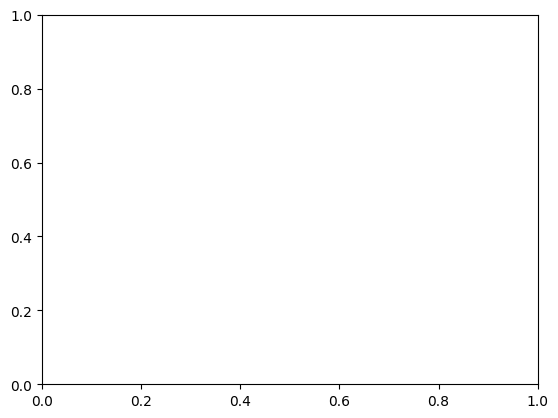

In [27]:
import matplotlib.pyplot as plt

# Define the x and y values for the plot
x = min_freq
y = [correlation.correlation for correlation in spearman_rank_correlations.values()]

# Create the plot
plt.plot(x, y)
plt.xlabel('Minimum Frequency')
plt.ylabel('Spearman Rank Correlation')
plt.title('Spearman Rank Correlation vs Minimum Frequency')
plt.show()